In [1]:
from src.data_preparation.data_preparation import read_eeg_file, read_eeg_files
from scipy import signal
from src.algorithms.csp.CSP import CSP
import pywt
from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from src.evaluation.evaluation import plot_accuracies_by_subjects
import numpy as np

Declaration of important values used during the pipeline 

In [2]:
TIME_LENGTH = 300
TIME_WINDOW = 300
EPOCH_SIZE = None
DATA_FOLDER = "data/bci-csp-based/bci-iii-dataset-iv-a"
CSP_COMPONENTS = 8
FS = 100
WAVELET = "coif1"

Create the subjects object and a dictionary to store the accuracies

In [3]:
subjects = range(1, 6)
subjects_set = set(subjects)
accuracies = {
    "GNB": np.zeros((len(subjects))),
    "SVM": np.zeros((len(subjects))),
    "LDA": np.zeros((len(subjects)))
}

Iterate on the subjects applying the algorithm, validating the results using the technique one subject out cross validation, to verify the stability of the algorithm to different subjects

In [4]:
for test_subject in subjects:
    print("Test subject: ", test_subject)
    training_subjects = list(subjects_set - {test_subject})
    print("Training subjects: ", training_subjects)

    # Load training data
    print("Loading training data ...")
    path_files = [(f"{DATA_FOLDER}/left-hand-subject-{training_subject}.csv",
                   f"{DATA_FOLDER}/right-hand-subject-{training_subject}.csv")
                  for training_subject in training_subjects]
    training_data = read_eeg_files(path_files, TIME_LENGTH, TIME_WINDOW, EPOCH_SIZE)

    # Load test data
    print("Loading test data ...")
    left_data_file = f"{DATA_FOLDER}/left-hand-subject-{test_subject}.csv"
    right_data_file = f"{DATA_FOLDER}/right-hand-subject-{test_subject}.csv"
    test_data = read_eeg_file(left_data_file, right_data_file, TIME_LENGTH, TIME_WINDOW, EPOCH_SIZE, False)

    # Pre-processing
    print("Pre-processing ...")
    print("Applying 5º order Butterworth bandpass filter (7-30 Hz)")
    b, a = signal.butter(5, [7, 30], btype="bandpass", fs=FS)

    training_data.left_data = signal.filtfilt(b, a, training_data.left_data, axis=1)
    training_data.right_data = signal.filtfilt(b, a, training_data.right_data, axis=1)

    test_data.left_data = signal.filtfilt(b, a, test_data.left_data, axis=1)
    test_data.right_data = signal.filtfilt(b, a, test_data.right_data, axis=1)

    print("Spatial-filtering ...")
    training_data.X = np.concatenate((training_data.left_data, training_data.right_data))
    test_data.X = np.concatenate((test_data.left_data, test_data.right_data))

    csp = CSP(average_trial_covariance=True, n_components=CSP_COMPONENTS)
    csp.fit(training_data.left_data, training_data.right_data)
    training_data.Z = np.array([csp.project(x) for x in training_data.X])

    csp = CSP(average_trial_covariance=True, n_components=CSP_COMPONENTS)
    csp.fit(test_data.left_data, test_data.right_data)
    test_data.Z = np.array([csp.project(x) for x in test_data.X])

    # Feature extraction
    print("Extracting features ...")
    training_data.F = np.zeros((training_data.X.shape[0], 2, CSP_COMPONENTS))
    for n_epoch in range(0, training_data.X.shape[0]):
        epoch = training_data.Z[n_epoch]

        # Calculate the wavelet features
        for n_feature in range(0, training_data.F.shape[2]):
            alpha_band, beta_band = pywt.dwt(epoch[:, n_feature], WAVELET)
            training_data.F[n_epoch, 0, n_feature] = np.sum(beta_band ** 2)

        # Calculate the frequency-domain features
        psd_window_size = 100
        psd_window_overlap = psd_window_size//2
        beta_freqs = range(13, 31)
        for n_feature in range(0, training_data.F.shape[2]):
            freq, psd = signal.welch(epoch[:, n_feature], fs=FS, window="hanning",
                                     nperseg=psd_window_size, noverlap=psd_window_overlap)
            training_data.F[n_epoch, 1, n_feature] = np.sum(psd[beta_freqs] ** 2)

    test_data.F = np.zeros((test_data.X.shape[0], 2, CSP_COMPONENTS))
    for n_epoch in range(0, test_data.X.shape[0]):
        epoch = test_data.Z[n_epoch]

        # Calculate the wavelet features
        for n_feature in range(0, test_data.F.shape[2]):
            alpha_band, beta_band = pywt.dwt(epoch[:, n_feature], WAVELET)
            test_data.F[n_epoch, 0, n_feature] = np.sum(beta_band ** 2)

        # Calculate the frequency-domain features
        psd_window_size = 100
        psd_window_overlap = psd_window_size // 2
        beta_freqs = range(13, 31)
        for n_feature in range(0, test_data.F.shape[2]):
            freq, psd = signal.welch(epoch[:, n_feature], fs=FS, window="hanning",
                                     nperseg=psd_window_size, noverlap=psd_window_overlap)
            test_data.F[n_epoch, 1, n_feature] = np.sum(psd[beta_freqs] ** 2)

    len_features = training_data.F.shape[1] * training_data.F.shape[2]
    training_data.F = np.reshape(training_data.F, newshape=(training_data.F.shape[0], len_features))
    test_data.F = np.reshape(test_data.F, newshape=(test_data.F.shape[0], len_features))

    # Feature normalization
    training_data.F = stats.zscore(training_data.F, axis=0)
    test_data.F = stats.zscore(test_data.F, axis=0)

    # Classification
    print("Classifying features ...")
    subject_index = test_subject - 1

    # GNB classifier
    gnb = GaussianNB()
    gnb.fit(training_data.F, training_data.labels)
    gnb_predictions = gnb.predict(test_data.F)
    gnb_accuracy = accuracy_score(test_data.labels, gnb_predictions)
    print(f"GNB accuracy: {gnb_accuracy:.4f}")
    accuracies["GNB"][subject_index] = gnb_accuracy

    # SVM classifier
    svm = SVC(C=.8, gamma="scale", kernel="rbf")
    svm.fit(training_data.F, training_data.labels)
    svm_predictions = svm.predict(test_data.F)
    svm_accuracy = accuracy_score(test_data.labels, svm_predictions)
    print(f"SVM accuracy: {svm_accuracy:.4f}")
    accuracies["SVM"][subject_index] = svm_accuracy

    # LDA classifier
    lda = LinearDiscriminantAnalysis()
    lda.fit(training_data.F, training_data.labels)
    lda_predictions = lda.predict(test_data.F)
    lda_accuracy = accuracy_score(test_data.labels, lda_predictions)
    print(f"LDA accuracy: {lda_accuracy:.4f}")
    accuracies["LDA"][subject_index] = lda_accuracy

    print()

Test subject:  1
Training subjects:  [2, 3, 4, 5]
Loading training data ...
Loading test data ...
Pre-processing ...
Applying 5º order Butterworth bandpass filter (7-30 Hz)
Spatial-filtering ...
Extracting features ...
Classifying features ...
GNB accuracy: 0.4679
SVM accuracy: 0.7607
LDA accuracy: 0.7286

Test subject:  2
Training subjects:  [1, 3, 4, 5]
Loading training data ...
Loading test data ...
Pre-processing ...
Applying 5º order Butterworth bandpass filter (7-30 Hz)
Spatial-filtering ...
Extracting features ...
Classifying features ...
GNB accuracy: 0.7893
SVM accuracy: 0.8429
LDA accuracy: 0.8393

Test subject:  3
Training subjects:  [1, 2, 4, 5]
Loading training data ...
Loading test data ...
Pre-processing ...
Applying 5º order Butterworth bandpass filter (7-30 Hz)
Spatial-filtering ...
Extracting features ...
Classifying features ...
GNB accuracy: 0.6607
SVM accuracy: 0.7357
LDA accuracy: 0.7179

Test subject:  4
Training subjects:  [1, 2, 3, 5]
Loading training data ...


Plot the accuracies obtained by subjects to each classification algorithm

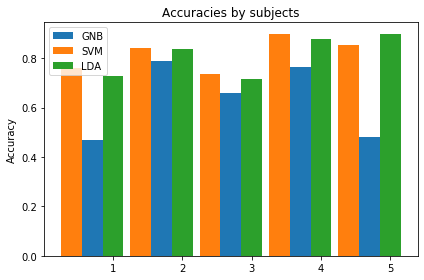

In [5]:
plot_accuracies_by_subjects(subjects, accuracies)

Print the results obtained by the 10-fold cross-validation from each classification algorithm

In [6]:
for classifier in accuracies.keys():
    print(classifier)
    for subject, acc in enumerate(accuracies[classifier]):
        print(f"\tSubject {subject+1} accuracy: {acc:.4f}")
    acc_mean = np.mean(accuracies[classifier])
    std_mean = np.std(accuracies[classifier])
    print(f"\tAverage accuracy: {acc_mean:.4f} +/- {std_mean:.4f}")


GNB
	Subject 1 accuracy: 0.4679
	Subject 2 accuracy: 0.7893
	Subject 3 accuracy: 0.6607
	Subject 4 accuracy: 0.7643
	Subject 5 accuracy: 0.4821
	Average accuracy: 0.6329 +/- 0.1360
SVM
	Subject 1 accuracy: 0.7607
	Subject 2 accuracy: 0.8429
	Subject 3 accuracy: 0.7357
	Subject 4 accuracy: 0.8964
	Subject 5 accuracy: 0.8536
	Average accuracy: 0.8179 +/- 0.0601
LDA
	Subject 1 accuracy: 0.7286
	Subject 2 accuracy: 0.8393
	Subject 3 accuracy: 0.7179
	Subject 4 accuracy: 0.8786
	Subject 5 accuracy: 0.9000
	Average accuracy: 0.8129 +/- 0.0758
